<a href="https://colab.research.google.com/github/sagihaider/TransferLearning_COVID19/blob/main/FineTuning_VGG16_COVID19_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 42.70 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [4]:
## unzip archives  q - quite, n - don't overwrite
!unzip -q -n '/content/COVID-CT/Images-processed/CT_COVID.zip'
!unzip -q -n '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

In [5]:
import os
path='/content/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid P cases:  348
Covid N cases:  396


In [6]:
base_dir = '/content/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

In [7]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

In [8]:
original_dataset_dir_covid = '/content/CT_COVID/'
original_dataset_dir_non_covid = '/content/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [9]:
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [12]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [13]:

def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [15]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(500, 224, 224, 3)
(100, 224, 224, 3)
(96, 224, 224, 3)


In [16]:
## VGG 16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [17]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [18]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [21]:
history = model.fit(train_X, train_y,
                              batch_size=20,
                              epochs=100, 
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/100
25/25 [==============================] - 3s 133ms/step - loss: 0.7016 - acc: 0.6820 - val_loss: 0.3819 - val_acc: 0.8300
Epoch 2/100
25/25 [==============================] - 3s 118ms/step - loss: 0.3069 - acc: 0.8560 - val_loss: 0.4301 - val_acc: 0.8200
Epoch 3/100
25/25 [==============================] - 3s 128ms/step - loss: 0.1861 - acc: 0.9380 - val_loss: 0.3223 - val_acc: 0.8600
Epoch 4/100
25/25 [==============================] - 3s 119ms/step - loss: 0.1338 - acc: 0.9540 - val_loss: 0.3262 - val_acc: 0.8600
Epoch 5/100
25/25 [==============================] - 3s 127ms/step - loss: 0.0718 - acc: 0.9900 - val_loss: 0.3025 - val_acc: 0.9100
Epoch 6/100
25/25 [==============================] - 3s 120ms/step - loss: 0.0602 - acc: 0.9920 - val_loss: 0.3484 - val_acc: 0.8400
Epoch 7/100
25/25 [==============================] - 3s 120ms/step - loss: 0.0278 - acc: 0.9960 - val_loss: 0.3467 - val_acc: 0.8700
Epoch 8/100
25/25 [==============================] - 3s 122ms/step - 

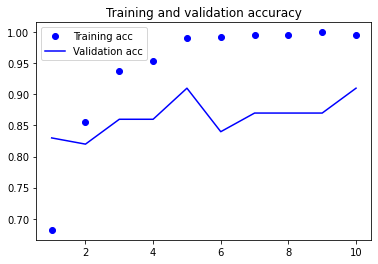

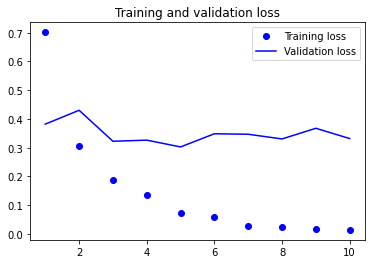

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:

from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)


Train Accuracy:	 0.9959999918937683
Val Accuracy:	 0.9100000262260437
Test Accuracy:	 0.8854166666666666
Precision:	 0.9743589743589743
Recall:		 0.7916666666666666
F1 Score:	 0.8735632183908045
AUC:		 0.8854166666666665
